In [1]:
import os
import sys
import copy
import pyproj
import collections
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from mintpy.constants import EARTH_RADIUS
from mintpy.objects.euler_pole import *
from mintpy.cli.plate_motion import ITRF2014_PMM, PMM_UNIT

from sphericalpolygon import Sphericalpolygon

In [19]:
def load_bnds(filename, order='lalo'):
    """Load the plate boundary text files
    Paramters:
        filename - filename of the boundary text file
        order    - the order of columns, 'lalo' or 'lola'
    Returns:
        Bnds     - a dictionary that contains a list of vertices of the plate polygon
    """
    Bnds = {}
    with open(filename, 'r') as f:
        lines = f.readlines()
        key, vertices = None, None
        for line in lines:
            if line.startswith('> ') or line.startswith('# ') or len(line.split())==1:
                if key and vertices:
                    Bnds[key] = np.array(vertices)
                if   line.startswith('> '): key = line.split('> ')[1]
                elif line.startswith('# '): key = line.split('# ')[1]
                else: key = str(line)
                if key.endswith('\n'):      key = key.split('\n')[0]
                vertices = []
            else:
                if order == 'lalo':
                    vert = np.array(line.split()).astype(float)
                elif order == 'lola':
                    vert = np.flip(np.array(line.split()).astype(float))
                vertices.append(vert)
    return Bnds


def polygon_attributes(polygon):
    """Get attributes of a sphericalpolygon object 
    Parameters:
        polygon      - object created from an instance of class Sphericalpolygon
                       (https://pypi.org/project/sphericalpolygon/)
    Returns:
        centroid_lat - latitude of centroid
        centroid_lon - longitude of centroid
    """
    Re          = 1e-3 * EARTH_RADIUS  # Earth radius in km
    centroid    = polygon.centroid(Re)
    centroid_lat, centroid_lon = centroid[:2]

    ## Other attributes (not used now)
    #--------------------------------------------    
    thickness   = 100.                 # plate thinckness in km
    density     = 3.1                  # density in g/cm3
    rho         = thickness * density  # Area density in km*g/cm3
    area        = polygon.area(Re)
    perimeter   = polygon.perimeter(Re)
    compactness = polygon.compactness()
    inertia     = polygon.inertia(Re,rho)
    #--------------------------------------------
    return centroid_lat, centroid_lon


def generate_sample_in_polygon(polygon, nx=10, ny=10):
    """Make a set of points inside the defined sphericalpolygon object
    Parameters:
        polygon - the sphericalpolygon object
        nx      - the number of points in the x (lon) direction
        ny      - the number of points in the y (lat) direction
    Returns:
        sample  - tuple that contains the coordinate (lats, lons) of the generated points
    """
    Point = collections.namedtuple('Points', 'lats lons vertices')
    lats = np.linspace(np.min(polygon.lats), np.max(polygon.lats), ny)
    lons = np.linspace(np.min(polygon.lons), np.max(polygon.lons), nx)
    lats, lons = np.meshgrid(lats, lons)
    vertices = np.vstack([lats.flatten(), lons.flatten()]).T
    
    # check which points are inside the polygon
    in_idx = polygon.contains_points(vertices)
    in_idx = np.array(in_idx).reshape(lats.shape)
    lons = lons[in_idx]
    lats = lats[in_idx]
    vertices = vertices[in_idx.reshape(len(vertices),)]
    sample   = Point(lats=lats, lons=lons, vertices=vertices)
    return sample



def plot_map(polygon, plate_obj, center_lat=None, center_lon=None, qscale=100, unit_q=5, zoom=100, dpi=100, outfile=None, **kwargs):
    """Plot the globe map wityh plate boundary, quivers on some points
    Parameters:
        polygon   - a sphericalpolygon object created from an instance of class Sphericalpolygon
                    (https://pypi.org/project/sphericalpolygon/)
        plate_obj - an EulerPole object created from an instance of class EulerPole
                    (mintpy.objects.euler_pole)
        center_lat - center the map at this latitute
        center_lon - center the map at this longitude
        qscale     - scaling factor of the quiver
        unit_q     - what value of quiver legend
        zoom       - zoom the globe to see a narrower region
        dpi        - output figure dpi
        outfile    - output figure name
        kwargs     - dictionary for plotting
        
    Returns:
        Draw a map and save it
    """
    if 'c_ocean'     not in kwargs.keys():   kwargs['c_ocean']       = 'w'
    if 'c_land'      not in kwargs.keys():   kwargs['c_land']        = 'lightgray'
    if 'c_plate'     not in kwargs.keys():   kwargs['c_plate']       = 'mistyrose'
    if 'lw_coast'    not in kwargs.keys():   kwargs['lw_coast']      = 0.5
    if 'lw_pbond'    not in kwargs.keys():   kwargs['lw_pbond']      = 1
    if 'lc_pbond'    not in kwargs.keys():   kwargs['lc_pbond']      = 'coral'
    if 'alpha_plate' not in kwargs.keys():   kwargs['alpha_plate']   = 0.4
    if 'grid_ls'     not in kwargs.keys():   kwargs['grid_ls']       = '--'
    if 'grid_lw'     not in kwargs.keys():   kwargs['grid_lw']       = 0.3
    if 'grid_lc'     not in kwargs.keys():   kwargs['grid_lc']       = 'gray'
    if 'Nq'          not in kwargs.keys():   kwargs['Nq']            = 10
    if 'pts'         not in kwargs.keys():   kwargs['pts']           = None
    if 'pts_marker'  not in kwargs.keys():   kwargs['pts_marker']    = '^'
    if 'pts_ms'      not in kwargs.keys():   kwargs['pts_ms']        = 20
    if 'pts_mfc'     not in kwargs.keys():   kwargs['pts_mfc']       = 'r'
    if 'pts_mec'     not in kwargs.keys():   kwargs['pts_mec']       = 'k'
    if 'pts_mew'     not in kwargs.keys():   kwargs['pts_mew']       = 2

    # center the map
    if (center_lat is None) or (center_lon is None):
        center_lat, center_lon = polygon_attributes(polygon)
    
    # make a base map from cartopy
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(projection=ccrs.NearsidePerspective(center_lon, center_lat, satellite_height=6.5e7/zoom))
    ax.set_global()
    ax.gridlines(color=kwargs['grid_lc'], linestyle=kwargs['grid_ls'], xlocs=np.arange(-180,180,30), ylocs=np.linspace(-80,80,10), linewidth=kwargs['grid_lw'])
    ax.add_feature(cfeature.OCEAN, color=kwargs['c_ocean'])
    ax.add_feature(cfeature.LAND,  color=kwargs['c_land'])
    ax.add_feature(cfeature.COASTLINE, linewidth=kwargs['lw_coast'])

    # add the plate polygon
    if polygon:
        ax.plot(polygon.lons, polygon.lats, color=kwargs['lc_pbond'], transform=ccrs.Geodetic(), linewidth=kwargs['lw_pbond'])
        ax.fill(polygon.lons, polygon.lats, color=kwargs['c_plate'],  transform=ccrs.Geodetic(), alpha=kwargs['alpha_plate'])

        # select some points inside the polygon and calc PMM, ENU
        sample = generate_sample_in_polygon(polygon, nx=kwargs['Nq'], ny=kwargs['Nq'])

        # compute the plate motion from Euler rotation
        if plate_obj:
            ve, vn, vu = plate_obj.get_velocity_enu(lat=sample.lats, lon=sample.lons, alt=0.0, ellps=True, print_msg=True)
            ve *= 1e3
            vn *= 1e3
            vu *= 1e3
            norm = np.sqrt(ve**2 + vn**2)

            # correcting for "East" further toward polar region; re-normalize ve, vn
            ve /= np.cos(np.deg2rad(sample.lats))
            renorm = np.sqrt(ve**2 + vn**2)/norm
            ve /= renorm
            vn /= renorm

            # ---------- plot dots, vectors --------------
            ax.scatter(sample.lons, sample.lats, marker='.', s=20, color='k', transform=ccrs.PlateCarree())
            q = ax.quiver(sample.lons, sample.lats, ve,  vn, transform=ccrs.PlateCarree(), scale=qscale, width=.0075, color='coral', angles="xy")
            ax.set_title('  ', pad=10) # put an empty title for extra whitepace at the top
            ax.quiverkey(q, X=0.3, Y=0.9, U=unit_q, label=f'{unit_q} mm/yr', labelpos='E', coordinates='figure')

    # add custom points (e.g., show some points of interest)
    if not kwargs['pts'] is None:
        ax.scatter(kwargs['pts'][1], kwargs['pts'][0], marker=kwargs['pts_marker'], s=kwargs['pts_ms'], 
                   fc=kwargs['pts_mfc'], ec=kwargs['pts_mec'], lw=kwargs['pts_mew'], transform=ccrs.PlateCarree())
    # save figure
    if outfile:
        print('save figure to file:', outfile)
        fig.savefig(outfile, bbox_inches='tight', transparent=True, dpi=300)

    plt.show()

In [23]:
# ===============================
# Plate boundary polygon
# ===============================

# Read Boundaries polygon file
database = '/home/ykliu/apps/MintPy/src/mintpy/data/plate_boundary'
#modelname = 'NNR-MORVEL56'
modelname = 'GSRMv2.1'

if modelname == 'NNR-MORVEL56':
    bnds_file = os.path.join('NnrMRVL_PltBndsLatLon/','All_boundaries')
    order = 'lalo'
elif modelname == 'GSRMv2.1':
    bnds_file = os.path.join('NnrGSRMv2.1_PltBndsLatLon/','GSRM_plate_outlines.gmt')
    order = 'lola'

Bnds = load_bnds(os.path.join(database, bnds_file), order)


# Initialize the polygon object of interest 
# (the abbreviated plate names may be different in two files. Check https://github.com/yuankailiu/PlateTectonic/tree/main/platemotion/data)
name = 'AR'
vertices = Bnds[name]
polygon  = Sphericalpolygon(vertices)


In [21]:
# ===============================
# Euler pole rotation definition
# ===============================

# Read Euler pole of Sinai plate in ITRF2014 from the paper of Castro-Perdomo et al., 2022
print(sph2cart(54.7, 347.8, r=0.417/MASY2DMY), 'mas per yr')

# append new custom subplate 
Tag = collections.namedtuple('Tag', 'name num_site omega_x omega_y omega_z omega wrms_e wrms_n')
ITRF2014_PMM['SINA'] = Tag('Sinai', -999, 0.848, -0.183, 1.225,  0.0,  0.0,  0.0)


# plate motion of some plates of interest
tag = ITRF2014_PMM['ARAB']
plate_arab = EulerPole(wx=tag.omega_x, wy=tag.omega_y, wz=tag.omega_z, unit='mas/yr')
tag = ITRF2014_PMM['SINA']
plate_sinai = EulerPole(wx=tag.omega_x, wy=tag.omega_y, wz=tag.omega_z, unit='mas/yr')


# relative motion between two plates
plate_ar_si = plate_arab - plate_sinai

(0.8478886087323123, -0.18332000605338197, 1.2251857502283363) mas per yr


assume a spheroidal Earth as defined in WGS84


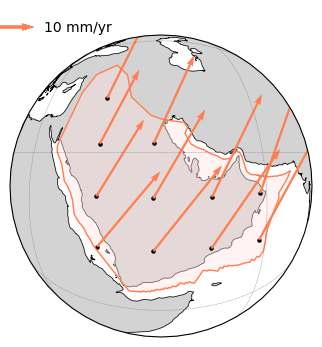

In [22]:
# ==================================
# Plot the globe with plate motion
# ==================================
kwargs = {'Nq': 6}

plot_map(polygon, plate_ar_si, qscale=20, unit_q=10, zoom=80, dpi=100, outfile=None, **kwargs)

save figure to file: makran_globe


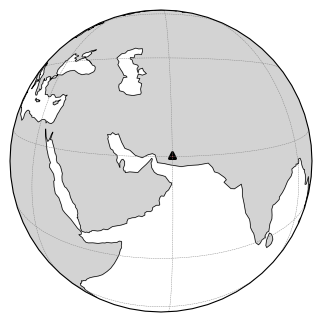

In [13]:
# ==================================
# Plot the globe without plate, only show the region
# ==================================
kwargs = {'Nq'  : 6,
          'pts' : [27, 60]}

plot_map(False, False, 26, 58, zoom=25, dpi=100, outfile='makran_globe', **kwargs)